<a href="https://colab.research.google.com/github/vfunnny2000/NN/blob/main/HW_6/HW_6_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install matplotlib


In [38]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [39]:
class RemoteSensingDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        mask_name = os.path.join(self.masks_dir, self.images[idx].replace('.jpg', '.png'))
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [40]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [41]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [42]:
# Задаем параметры
batch_size = 4
learning_rate = 1e-3
epochs = 20

In [43]:
# Подготовка данных
train_ds = RemoteSensingDataset(images_dir='dataset/train/images',
                                masks_dir='dataset/train/masks',
                                transform=transforms.ToTensor())

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)



In [44]:
# Инициализация модели, оптимизатора и функции потерь
model = UNet()
criterion = nn.BCEWithLogitsLoss()  # Для задачи бинарной классификации
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
# Обучение модели
for epoch in range(epochs):
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.6893789768218994
Epoch 2, Loss: 0.6651903390884399
Epoch 3, Loss: 0.6759504675865173
Epoch 4, Loss: 0.6623836159706116
Epoch 5, Loss: 0.6542284488677979
Epoch 6, Loss: 0.6553534269332886
Epoch 7, Loss: 0.6471134424209595
Epoch 8, Loss: 0.6547227501869202
Epoch 9, Loss: 0.6534854173660278
Epoch 10, Loss: 0.6730808615684509
Epoch 11, Loss: 0.6661166548728943
Epoch 12, Loss: 0.6565011739730835
Epoch 13, Loss: 0.6487758159637451
Epoch 14, Loss: 0.6615414619445801
Epoch 15, Loss: 0.6472181677818298
Epoch 16, Loss: 0.6753938794136047
Epoch 17, Loss: 0.6435081958770752
Epoch 18, Loss: 0.6647201180458069
Epoch 19, Loss: 0.6453574895858765
Epoch 20, Loss: 0.6371622085571289


In [46]:
def plot_img_and_mask(img, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(transforms.ToPILImage()(img), cmap="gray")
    ax1.set_title('Original Image')
    ax2.imshow(transforms.ToPILImage()(mask), cmap="gray")
    ax2.set_title('Mask')
    plt.show()

In [49]:
# Подготовка тестового набора данных
test_ds = RemoteSensingDataset(images_dir='dataset/test/images',
                               masks_dir='dataset/test/masks',
                               transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

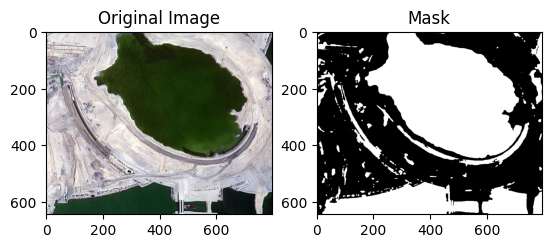

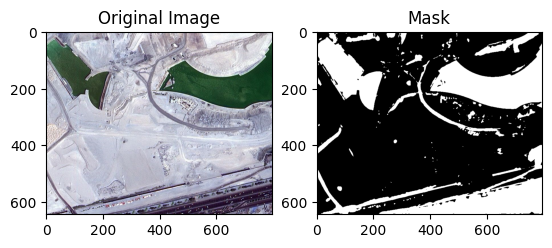

In [50]:
# Вывод изображений и соответствующих масок
model.eval()  # Переключите модель в режим оценки
with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images)
        pred_mask = torch.sigmoid(outputs)
        pred_mask = (pred_mask > 0.5) * 1.0  # Бинаризация маски
        plot_img_and_mask(images[0], pred_mask[0])